# Cluster Analysis




In [54]:
import sys
sys.path.append("..")
from benchmark.results import load_all_results
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


sns.set(rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_style("whitegrid")

dim = {"aloi": 27, 
    "celeba": 39, 
    "census": 500, 
    "gist": 960, 
    "glove": 100, 
    "household": 7, 
    "mnist": 784, 
    "pamap2": 4,}

dataset = 'pamap2' # 'glove', 'gist', 'pamap2', 'household', 'mnist', 'celeba', 'census, 'aloi'
exact_algorithm = 'tpedbscan' # for high-dimensional datasets, this has to be 'faiss'

data = []
data2 = []

# load all the results that are available for the dataset
for f in load_all_results(dataset, ".."):
    # filter by the exact algorithm
    if f.attrs['algo'] == exact_algorithm: #and f.attrs['minPts'] == 10: # 650 for census, 200 for celeba and 20 for gist, 100 otherwise
        labels = np.array(f['labels'])
        points_clustered = len([x for x in np.array(labels) if x >= 0])
        largest_cluster_size = 0
        if len(labels[labels > -1]) > 0:
            largest_cluster_size = max(Counter(labels[labels > -1]).values())/len(labels)
        data.append({
            "eps": f.attrs['eps'],
            "minPts": f.attrs['minPts'],
            "n": len(labels),
            "num_clusters": len(set(labels)),
            "largest_cluster_size": largest_cluster_size, 
            "num_corepoints": len(f['corepoints']),
            "num_noncorepoints": len(labels) - len(f['corepoints']),
            "points_clustered": points_clustered,
            "fraction_clustered": points_clustered/len(labels),
            "fraction_noise": len([x for x in np.array(labels) if x < 0])/len(labels),
            "cluster_sizes": sorted(Counter(labels[labels > -1]).values(),reverse=True),
            #"Params": f.attrs['params'],
            #"time": f.attrs['time'],
            })
    if f.attrs['algo'] == 'srrdbscan' and f.attrs['params'][16:35].split(",")[0] == '0.1':
        data2.append({
            "eps": f.attrs['eps'],
            "time": f.attrs['time']
            })

df = pd.DataFrame(data=data)
df2 = pd.DataFrame(data=data2)
df

Text(0.5, 1.0, 'Number of clusters for celeba with minPts=200')

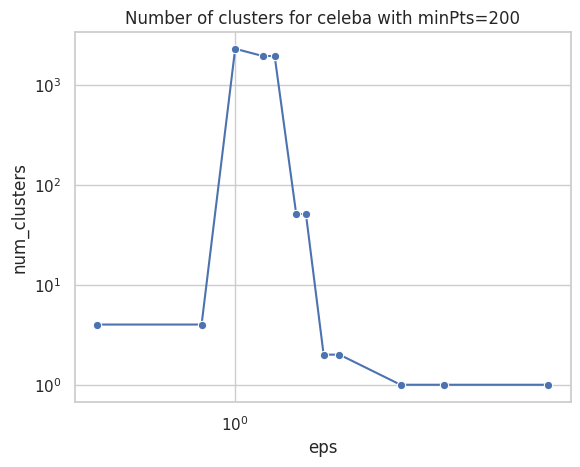

In [ ]:
minPts = max(df["minPts"])
ax = sns.lineplot(data=df, x='eps', y='num_clusters', marker='o')
ax.set_yscale('log')
ax.set_xscale('log')
ax.minorticks_on()
plt.title(f"Number of clusters for {dataset} with minPts={minPts}")


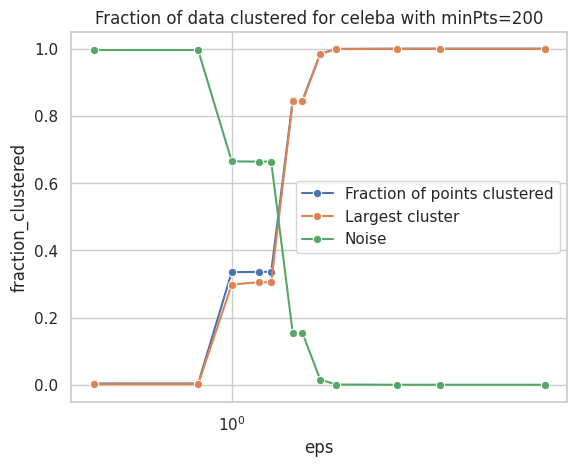

In [ ]:
ax = sns.lineplot(data=df, x='eps', y='fraction_clustered', marker='o', label="Fraction of points clustered")
sns.lineplot(ax=ax, data=df, x='eps', y='largest_cluster_size', marker='o', label="Largest cluster")
sns.lineplot(ax=ax, data=df, x='eps', y='fraction_noise', marker='o', label="Noise")
#ax.set_yscale('log')
ax.set_xscale('log')
ax.minorticks_on()
plt.title(f"Fraction of data clustered for {dataset} with minPts={minPts}")
# there is a mistake here, since we shouldn't look at the majority element
# much better scale: fraction of the dataset, see the Schubert et al. plots.
plt.legend()

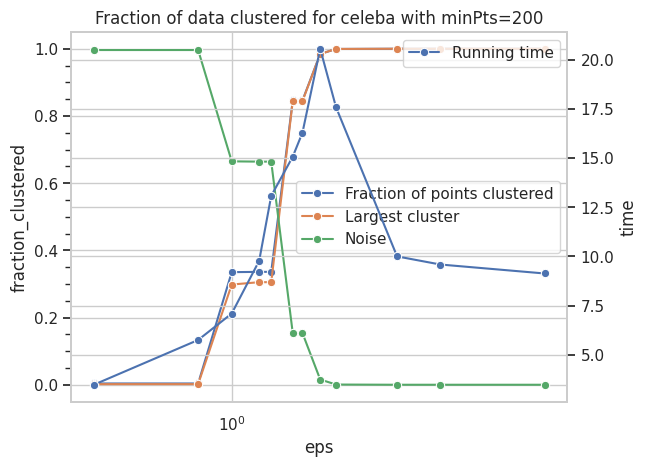

In [ ]:
ax = sns.lineplot(data=df, x='eps', y='fraction_clustered', marker='o', label="Fraction of points clustered")
sns.lineplot(ax=ax, data=df, x='eps', y='largest_cluster_size', marker='o', label="Largest cluster")
sns.lineplot(ax=ax, data=df, x='eps', y='fraction_noise', marker='o', label="Noise")
ax2 = plt.twinx()
sns.lineplot(ax=ax2, data=df2, x='eps', y='time', marker='o', label="Running time")
#ax.set_yscale('log')
ax.set_xscale('log')
ax.minorticks_on()
plt.title(f"Fraction of data clustered for {dataset} with minPts={minPts}")
# there is a mistake here, since we shouldn't look at the majority element
# much better scale: fraction of the dataset, see the Schubert et al. plots.
plt.legend()

In [ ]:
# Evaluating the cluster quality

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

dataset = 'celeba'

exact_algorithm = 'faiss'

data = []

exact_data = {}
for f in load_all_results(dataset, ".."):
    #if f.attrs['minPts'] == 200: # 650 for census, 200 f0r celeba and 20 for gist, 100 otherwise
    if f.attrs['algo'] == exact_algorithm:
        exact_data[f.attrs['eps']] = (np.array(f['labels']), np.array(f['corepoints']), np.array(f['borderpoints']))
    else:
        data.append({
            "clustering": np.array(f['labels']),
            "time": f.attrs['time'],
            "algo": f.attrs['algo'],
            "eps": f.attrs['eps'],
            "params": f.attrs.get("params", "")
        })

metrics = []

#print(exact_data)

for eps, (gt_labels, corepoints, borderpoints) in exact_data.items():
    filtered_data = [d for d in data if d['eps'] == eps]
    # remove border points
    gt_labels[borderpoints] = -1
    #print("corepoints:", corepoints)
    for d in filtered_data:
        labels = d["clustering"]
        labels[borderpoints] = -1
        metrics.append({
            "eps": eps,
            "time": d['time'],
            "algo": d["algo"],
            "ARI": adjusted_rand_score(gt_labels, labels),
            "NMI": normalized_mutual_info_score(gt_labels, labels),
            "params": d.get("params", "")
        })
        #if eps == 0.8:
            #print(eps, d["algo"], gt_labels[0:200], labels[0:200], adjusted_rand_score(gt_labels, labels))
if dataset == 'gist':
    quality_df = pd.DataFrame(data)
    quality_df.sort_values(by=["eps"])
else:
    quality_df = pd.DataFrame(metrics)
    quality_df.sort_values(by=["eps", "ARI", "NMI"])

Was unable to read 0.01_5_56, 1.hdf5


Traceback (most recent call last):
  File "/mnt/large_storage/dbscan/lshdbscan/evaluation/../benchmark/results.py", line 58, in load_all_results
    with h5py.File(os.path.join(root, filename), "r+") as f:
  File "/home/cabi/.local/lib/python3.8/site-packages/h5py/_hl/files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
  File "/home/cabi/.local/lib/python3.8/site-packages/h5py/_hl/files.py", line 233, in make_fid
    fid = h5f.open(name, h5f.ACC_RDWR, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 106, in h5py.h5f.open
BlockingIOError: [Errno 11] Unable to open file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable')


In [ ]:
if dataset != 'gist':
    for i in range(len(quality_df)):
        if quality_df['algo'][i] == 'srrdbscan':
            print(quality_df['params'][i][16:35].split(",")[0], str("&"),
                quality_df['eps'][i], str("&"),
                round(quality_df['time'][i], 2), str("&"),
                round(quality_df['ARI'][i], 4), str(r"\\"))
                #round(quality_df['NMI'][i], 4), str(r"\\"))

0.01 & 8.0 & 10.63 & 1.0 \\
0.9 & 8.0 & 4.72 & 0.0 \\
0.5 & 8.0 & 5.69 & 1.0 \\
0.1 & 8.0 & 9.13 & 1.0 \\
0.01 & 1.8 & 29.42 & 0.9988 \\
0.9 & 1.8 & 5.11 & 0.0965 \\
0.5 & 1.8 & 9.74 & 0.7359 \\
0.1 & 1.8 & 20.55 & 0.9727 \\
0.9 & 0.8 & 2.58 & 0.1926 \\
0.5 & 0.8 & 3.47 & 0.1926 \\
0.1 & 0.8 & 5.75 & 0.1926 \\
0.01 & 0.4 & 4.78 & 0.1926 \\
0.9 & 0.4 & 2.17 & 0.1926 \\
0.5 & 0.4 & 2.33 & 0.1926 \\
0.1 & 0.4 & 3.47 & 0.1926 \\
0.01 & 3.0 & 11.49 & 1.0 \\
0.9 & 3.0 & 5.31 & 0.0 \\
0.5 & 3.0 & 6.5 & 0.0 \\
0.1 & 3.0 & 10.0 & 1.0 \\
0.01 & 1.0 & 11.3 & 0.8691 \\
0.9 & 1.0 & 2.64 & 0.4388 \\
0.5 & 1.0 & 4.35 & 0.784 \\
0.1 & 1.0 & 7.09 & 0.8626 \\
0.01 & 1.6 & 29.04 & 0.9912 \\
0.9 & 1.6 & 4.49 & 0.1627 \\
0.5 & 1.6 & 7.71 & 0.8141 \\
0.1 & 1.6 & 16.29 & 0.9811 \\
0.01 & 4.0 & 10.75 & 1.0 \\
0.9 & 4.0 & 4.78 & 0.0 \\
0.5 & 4.0 & 5.85 & 1.0 \\
0.1 & 4.0 & 9.58 & 1.0 \\
0.01 & 2.0 & 22.59 & 0.9984 \\
0.9 & 2.0 & 6.2 & 0.125 \\
0.5 & 2.0 & 10.25 & 0.6542 \\
0.1 & 2.0 & 17.57 & 0.9544 \\
0.01 & 

# Running time plot

In [ ]:
if dataset != 'gist':
    data = []

    for i in range(len(pd.DataFrame(metrics)['ARI'])):
        if pd.DataFrame(metrics)['ARI'][i] > 0.7:
            data.append({
                "time": pd.DataFrame(metrics)['time'][i],
                "algo": pd.DataFrame(metrics)['algo'][i],
                "eps": pd.DataFrame(metrics)['eps'][i],
                })

    df = pd.DataFrame(data)
    df = pd.DataFrame(df.sort_values(by=["algo", "eps", "time"],ignore_index=True))

    #t = df.groupby(['algo', 'eps'])['time'].min()
    #print(df['time'][1])

    times = []
    times.append({
        "time": df['time'][0],
        "algo": df['algo'][0],
        "eps": df['eps'][0],
    })
    for i in range(1, len(df['time'])):
        if df['eps'][i] != df['eps'][i-1] or df['algo'][i] != df['algo'][i-1]:
            times.append({
                "time": df['time'][i],
                "algo": df['algo'][i],
                "eps": df['eps'][i],
            })

    for f in load_all_results(dataset, ".."):
        if f.attrs['algo'] == exact_algorithm:
            times.append({
                "time": f.attrs['time'],
                "algo": f.attrs['algo'],
                "eps": f.attrs['eps'],
            })

    times = pd.DataFrame(times)

Was unable to read 0.01_5_56, 1.hdf5


Traceback (most recent call last):
  File "/mnt/large_storage/dbscan/lshdbscan/evaluation/../benchmark/results.py", line 58, in load_all_results
    with h5py.File(os.path.join(root, filename), "r+") as f:
  File "/home/cabi/.local/lib/python3.8/site-packages/h5py/_hl/files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
  File "/home/cabi/.local/lib/python3.8/site-packages/h5py/_hl/files.py", line 233, in make_fid
    fid = h5f.open(name, h5f.ACC_RDWR, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 106, in h5py.h5f.open
BlockingIOError: [Errno 11] Unable to open file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable')


In [ ]:
if dataset == 'gist':
    data = pd.DataFrame(data)
    times = []
    for i in range(len(data['params'])):
        if data['params'][i][16:35].split(",")[0] == '0.1':
            times.append({
                        "time": data['time'][i],
                        "algo": 'srrdbscan',
                        "eps": data['eps'][i],
                    })

    times = pd.DataFrame(times)

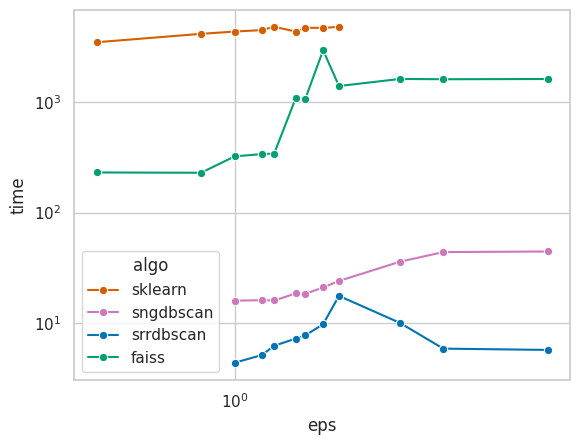

In [ ]:
palette = sns.color_palette("colorblind")
custom_palette = {"srrdbscan": palette[0], 
                  "tpedbscan": palette[1], 
                  "faiss": palette[2], 
                  "sklearn": palette[3], 
                  "sngdbscan": palette[4]}

ax = sns.lineplot(data=times, x='eps', y='time', hue="algo", marker='o', palette=custom_palette)
ax.set_xscale("log")
ax.set_yscale("log")

In [ ]:
Algo = ['srrdbscan', 'tpedbscan', 'faiss', 'sklearn', 'sngdbscan']
# eps = [0.0008, 0.002, 0.01, 0.03, 0.1] # aloi
# eps = [0.8, 1.2, 1.6, 2.0, 4.0] # celeba
eps = [0.03, 0.3, 1.0, 3.0, 8.0] # census
# eps = [0.3, 1.0, 1.3, 2.0, 6.0] # gist
# eps = [1.0, 4.0, 5.0, 10.0, 20.0] # glove
# eps = [0.05, 0.5, 16, 64, 500] # household
# eps = [1000, 1300, 1600, 1800, 4000] # mnist
# eps = [0.5, 1.0, 2.0, 7.0, 30.0] # pamap2

M = [[0 for _ in range(len(eps))] for _ in range(len(Algo))]
# M = np.zeros((len(Algo),len(eps)))
x=0
y=0

for i in range(len(times)):
    if times["eps"][i] in eps:
        x = Algo.index(times["algo"][i])
        y = eps.index(times["eps"][i])
        M[x][y] = str(round(times["time"][i], 2))

for i in range(len(Algo)):
    for j in range(len(eps)):
        if M[i][j] == 0.0:
            M[i][j] = 'Missing'

for j in range(len(eps)):
    print(str("&"), eps[j], str("&"), 
          M[0][j], str("&"), 
          M[1][j], str("&"), 
          M[2][j], str("&"), 
          M[3][j], str("&"), 
          M[4][j], str(r"\\"))

# for i in range(len(Algo)):
#     print(Algo[i])
#     for j in range(len(eps)):
#         print(M[i][j])

& 0.03 & Missing & Missing & Missing & Missing & Missing \\
& 0.3 & Missing & Missing & Missing & Missing & Missing \\
& 1.0 & 4.35 & Missing & 323.04 & 4369.72 & 15.91 \\
& 3.0 & 10.0 & Missing & 1625.85 & Missing & 35.87 \\
& 8.0 & 5.69 & Missing & 1623.72 & Missing & 44.39 \\


In [ ]:
for i in range(len(eps)): 
    print(eps[i])

0.03
0.3
1.0
3.0
8.0


Collective running time plot

In [ ]:
sets = {"aloi": [27, 0.0005, 0.2], 
    "celeba": [39, 0.4, 8.0], 
    "census": [500, 0.01, 10.0], 
    "gist": [960, 0.2, 10.0], 
    "glove": [100, 1, 20.0], 
    "household": [7, 0.01, 1000.0], 
    "mnist": [784, 500.0, 10000], 
    "pamap2": [4, 0.1, 500.0]}


data = []

for dataset in sets:
    for f in load_all_results(dataset, ".."):
        if f.attrs['algo'] == 'srrdbscan' and f.attrs['params'][16:35].split(",")[0] == '0.1':
            data.append({
                "data": dataset,
                "eps": (f.attrs['eps'] - sets[dataset][1])/(sets[dataset][2] - sets[dataset][1]),
                #"eps": f.attrs['eps']/sets[dataset][1],
                "time": f.attrs['time']/(len(f['labels'])*sets[dataset][0])
                })

df = pd.DataFrame(data=data)
df

Was unable to read 0.01_5_56, 1.hdf5


Traceback (most recent call last):
  File "/mnt/large_storage/dbscan/lshdbscan/evaluation/../benchmark/results.py", line 58, in load_all_results
    with h5py.File(os.path.join(root, filename), "r+") as f:
  File "/home/cabi/.local/lib/python3.8/site-packages/h5py/_hl/files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
  File "/home/cabi/.local/lib/python3.8/site-packages/h5py/_hl/files.py", line 233, in make_fid
    fid = h5f.open(name, h5f.ACC_RDWR, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 106, in h5py.h5f.open
BlockingIOError: [Errno 11] Unable to open file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable')


,data,eps,time
0,aloi,0.248120,2.874242e-06
1,aloi,0.001504,4.606162e-07
2,aloi,0.007519,4.447438e-07
3,aloi,0.147870,1.191670e-06
4,aloi,0.097744,6.877700e-07
...,...,...,...
90,pamap2,0.002200,1.734966e-06
91,pamap2,0.009802,9.416735e-06
92,pamap2,0.019804,5.482247e-06
93,pamap2,1.000000,3.141313e-06


/tmp/ipykernel_2103557/4029657802.py:3: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  ax = sns.lineplot(data=df, x='eps', y='time', hue="data", marker='o', palette=palette)


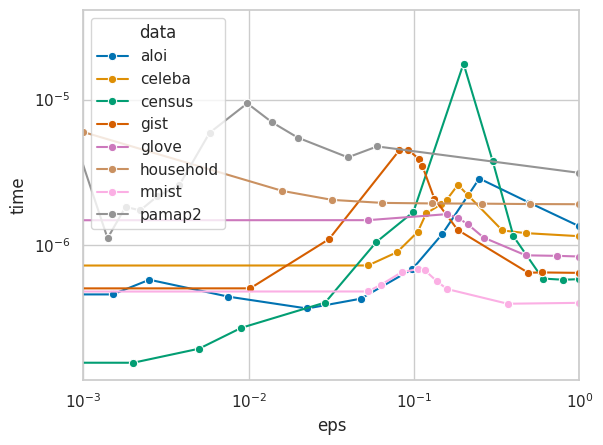

In [ ]:
palette = sns.color_palette("colorblind")

ax = sns.lineplot(data=df, x='eps', y='time', hue="data", marker='o', palette=palette)
ax.set_xlim(0.001, 1)
ax.set_xscale("log")
ax.set_yscale("log")